In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

In [4]:
data_dir = 'gesture_data'
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]



In [10]:
df_list = [pd.read_csv(file) for file in all_files]
data = pd.concat(df_list, ignore_index=True)

print(f"Total samples: {len(data)}")
data.head()
#data.tail()

Total samples: 72000


,ch1,ch2,timestamp_ms,label
0,549,525,0,clenched
1,534,488,10,clenched
2,513,529,20,clenched
3,502,514,30,clenched
4,526,490,40,clenched


In [11]:
samples_per_window = 20
feature_rows = []

for start in range(0, len(data), samples_per_window):
    end = start + samples_per_window
    window = data.iloc[start:end]

    if len(window) < samples_per_window:
        continue

    # Extract signal
    ch1 = window['ch1'].values
    ch2 = window['ch2'].values

    # Compute features
    rms_ch1 = np.sqrt(np.mean(ch1 ** 2))
    rms_ch2 = np.sqrt(np.mean(ch2 ** 2))
    mav_ch1 = np.mean(np.abs(ch1))
    mav_ch2 = np.mean(np.abs(ch2))
    mse_ch1 = np.mean((ch1 - np.mean(ch1)) ** 2)
    mse_ch2 = np.mean((ch2 - np.mean(ch2)) ** 2)

    label = window['label'].mode()[0]  # mode gives most common label

    feature_rows.append([rms_ch1, rms_ch2, mav_ch1, mav_ch2, mse_ch1, mse_ch2, label])

In [12]:
columns = ['rms_ch1', 'rms_ch2', 'mav_ch1', 'mav_ch2', 'mse_ch1', 'mse_ch2', 'label']
final_data = pd.DataFrame(feature_rows, columns=columns)
print(final_data.head())

      rms_ch1     rms_ch2  mav_ch1  mav_ch2   mse_ch1   mse_ch2     label
0  529.310353  506.003953   529.05   505.80  275.5475  206.3600  clenched
1  526.139668  506.722952   525.95   506.55  199.5475  175.2475  clenched
2  522.030650  505.491988   521.90   505.25  136.3900  244.5875  clenched
3  529.099282  506.722261   528.95   506.55  157.9475  174.5475  clenched
4  524.127418  502.474477   523.85   502.30  290.7275  175.3100  clenched


In [13]:

le = LabelEncoder()
final_data['label_encoded'] = le.fit_transform(final_data['label'])

# Mapping of encoded labels to gesture names
label_map = dict(zip(le.transform(le.classes_), le.classes_))
print("Label mapping:", label_map)


Label mapping: {0: 'clenched', 1: 'fist', 2: 'four', 3: 'index_finger', 4: 'okay', 5: 'peace', 6: 'rest', 7: 'rock', 8: 'spread', 9: 'three', 10: 'thumb', 11: 'up'}


In [15]:

X = final_data[['rms_ch1', 'rms_ch2', 'mav_ch1', 'mav_ch2', 'mse_ch1', 'mse_ch2']]
y = final_data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 2880, Test size: 720


In [16]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [17]:
y_pred = model.predict(X_test)

# for metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

    clenched       0.06      0.02      0.03        60
        fist       0.09      0.32      0.14        60
        four       0.09      0.17      0.12        60
index_finger       0.00      0.00      0.00        60
        okay       0.00      0.00      0.00        60
       peace       0.11      0.17      0.13        60
        rest       0.00      0.00      0.00        60
        rock       0.04      0.02      0.02        60
      spread       0.08      0.20      0.11        60
       three       0.07      0.10      0.08        60
       thumb       0.00      0.00      0.00        60
          up       0.00      0.00      0.00        60

    accuracy                           0.08       720
   macro avg       0.04      0.08      0.05       720
weighted avg       0.04      0.08      0.05       720



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


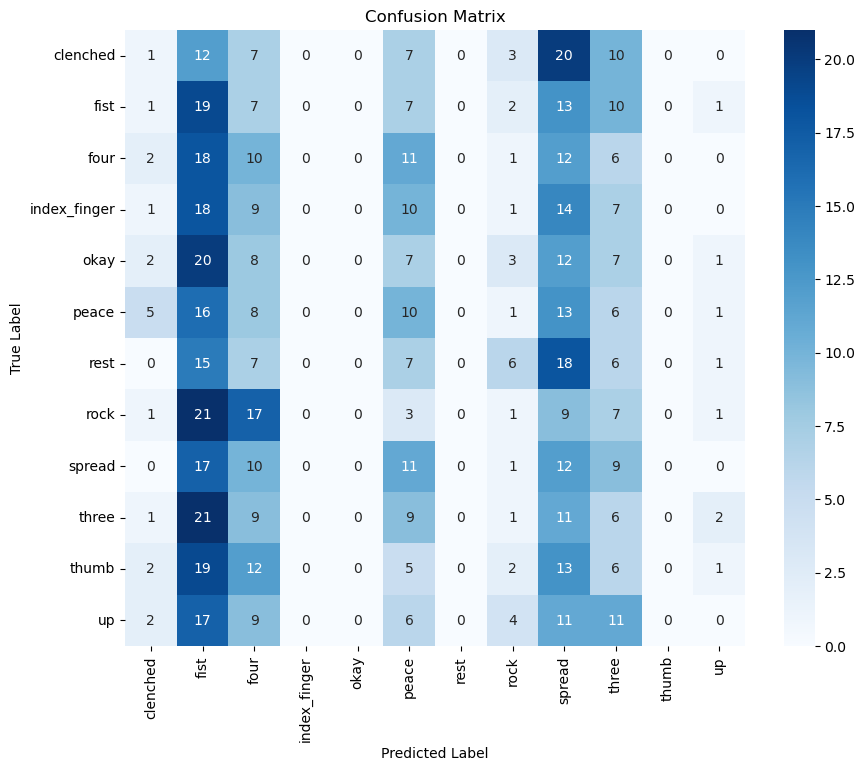

In [18]:

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

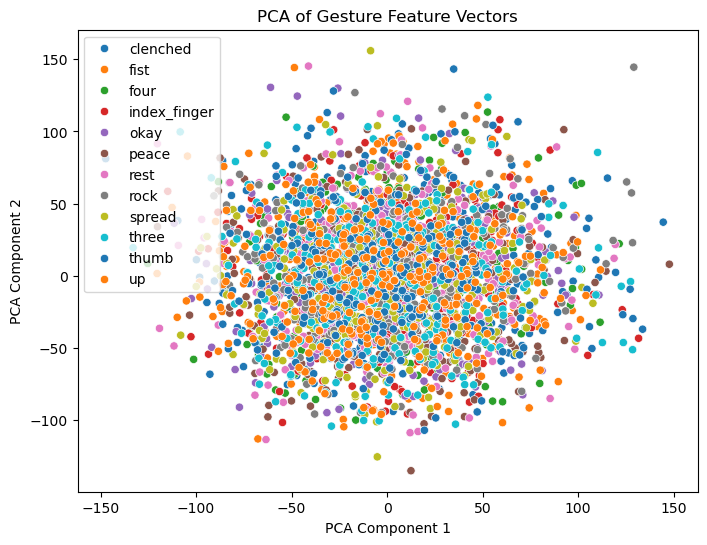

In [19]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=le.inverse_transform(y), palette='tab10')

plt.title("PCA of Gesture Feature Vectors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc='best')
plt.show()